<a href="https://colab.research.google.com/github/fxop0218/Tutorial-PyTorchForBeginners/blob/main/05_custom_dataset_pytorch_beginners.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch Custom Dataset to Beginners

## 1. Import // setting device-agnostic

In [53]:
import torch # PyTorch 1.10.0 + required
from torch import nn

print(f"Torch version: {torch.__version__}")

Torch version: 1.13.0+cu116


In [54]:
# Setup device-agnostic
device = "cuda" if torch.cuda.is_available() else "cuda"
print(f"Device: {device}")

Device: cuda


## 2. Get data

**🟦ES**: Our dataset in a subset of the Food101 dataset

Food101 starts 101 different classes of food and 1000 images per class (75% training and 25% testing) 

Our dataset starts with 3 classes of food and only 10% of the images.

When startitng out ML model, it's important to try things on a small scale and then increase the sacle when necessary.

The whole point is to speed up how fast you can experiment.

**🟥EN**: Nuestro conjunto de datos en un subconjunto del conjunto de datos Food101

Food101 comienza con 101 clases diferentes de alimentos y 1000 imágenes por clase (75% de entrenamiento y 25% de prueba) 

Nuestro conjunto de datos comienza con 3 clases de alimentos y sólo el 10% de las imágenes.

Cuando se inicia un modelo ML, es importante probar las cosas a pequeña escala y luego aumentar el saco cuando sea necesario.

El objetivo es acelerar la velocidad de experimentación.

 

In [55]:
import requests 
import zipfile
from pathlib import Path

# Startup patht to a data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"
ZIP_FILE = "pizza_steak_sushi.zip"

In [56]:
# Download only if the image folder exists
if image_path.is_dir():
  print(f"The directory {image_path} already exists...")
else:
  print(f"The directory {image_path} does not exists...")
  image_path.mkdir(parents=True, exist_ok=True)

The directory data/pizza_steak_sushi already exists...


In [57]:
# Download

with open(data_path / ZIP_FILE, "wb") as f:
  request = requests.get("https://github.com/mahdiislam79/Pizza_steak_sushi_prediction_Pytorch/raw/main/data/pizza_steak_sushi.zip")
  f.write(request.content)

with zipfile.ZipFile(data_path / ZIP_FILE, "r") as f:
  f.extractall(image_path)
  print(f"Extracted correctly {ZIP_FILE} into {image_path}")


Extracted correctly pizza_steak_sushi.zip into data/pizza_steak_sushi


## 3. Data modification

In [58]:
import os
def to_dir(directory_path):
  for dirpath, dirnames, filenames in os.walk(directory_path):
    print(f"Number of directories  {len(dirnames)} || Number of images {len(filenames)} in {dirpath}")

In [59]:
to_dir(image_path)

Number of directories  2 || Number of images 0 in data/pizza_steak_sushi
Number of directories  3 || Number of images 0 in data/pizza_steak_sushi/train
Number of directories  0 || Number of images 75 in data/pizza_steak_sushi/train/steak
Number of directories  0 || Number of images 78 in data/pizza_steak_sushi/train/pizza
Number of directories  0 || Number of images 72 in data/pizza_steak_sushi/train/sushi
Number of directories  3 || Number of images 0 in data/pizza_steak_sushi/test
Number of directories  0 || Number of images 19 in data/pizza_steak_sushi/test/steak
Number of directories  0 || Number of images 25 in data/pizza_steak_sushi/test/pizza
Number of directories  0 || Number of images 31 in data/pizza_steak_sushi/test/sushi


In [60]:
train_dir = image_path / "train"
test_dir = image_path / "test"

### 3.1 Visualizing data

**🟦EN**:
1. Get all the paths of the images.
2. Pick random image.
3. Get image with their class name. 
4. Open images with Python PIL.
5. We'll then show the image and print metadata.
**🟥ES**:
1. Conseguir todos los directorios de las imagenes. 
2. Coger una imagen random
3. Coger imagenes con su classe
4. Abrir las imagener con Python PIL
5. Mostrar el Metadata de la imagen

In [61]:
from PIL import Image
import random

# Seed
random.seed(10)

# Get paths
image_list = list(image_path.glob("*/*/*.jpg"))

# Pick random image
rand_img = random.choice(image_list)
print(f"Random image directory: {rand_img}")

# Get image class from path, in this case, the class is the folder that contains the image
img_class = rand_img.parent.stem
print(f"Class: {img_class}")

# Open img
img = Image.open(rand_img)

Random image directory: data/pizza_steak_sushi/test/sushi/1245193.jpg
Class: sushi


Image path: data/pizza_steak_sushi/test/sushi/1245193.jpg
Class: sushi
Height: 295 Width: 512


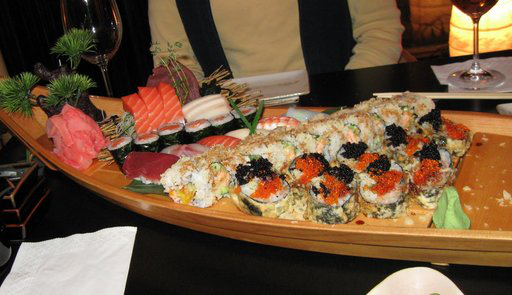

In [62]:
print(f"Image path: {rand_img}\nClass: {img_class}\nHeight: {img.height} Width: {img.width}")
img

Image shape: (295, 512, 3)


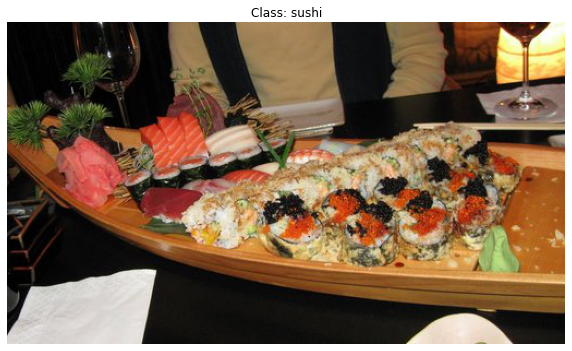

In [63]:
import matplotlib.pyplot as plt
import numpy as np

# Image => Array
img_array = np.asarray(img)

# Plot img
plt.figure(figsize=(10, 10))
plt.imshow(img_array)
plt.title(f"Class: {img_class}")
plt.axis(False)

print(f"Image shape: {img_array.shape}")

## 4. Data manipulation

**🟦EN**: Before we can use image data with PyTorch
1. Turn target data into tensors
2. Turn it into a `torch.utils.data.Dataset` as subsequently a `torch.utils.data.DataLoader`

**🟥ES**:


In [64]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transform img with `torchvision.transform`

**🟦EN**: Transform data is required to use with a model

**🟥ES**: La transformación de datos es necesaria para su uso con un modelo


In [65]:
img_transform = transforms.Compose([
    # Resize img to (x, y) in this case x, y = 64
    transforms.Resize(size=(64, 64)),
    # Flip image randomly
    transforms.RandomHorizontalFlip(p=0.5),
    # Image => torch.Tensor
    transforms.ToTensor(),
])

In [66]:
img_t = img_transform(img)
print(f"Image shape: {img_t.shape} [color_channel, height, width]")

Image shape: torch.Size([3, 64, 64]) [color_channel, height, width]


In [79]:
def plot_transformed_images(image_paths, transform, n=6, seed=10):

  # Put random seed if exists
  if seed:
    random.seed(seed)
  rand_img = random.sample(image_paths, k=n)

  for image_path in rand_img:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Non Modified Size: {f.size}")
      ax[0].axis(False)

      # Transform and plto to see the diff
      trans_img = transform(f).permute(1, 2, 0) # (C, H, W)
      ax[1].imshow(trans_img)
      ax[1].set_title(f"Modified Size: {trans_img.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=20)

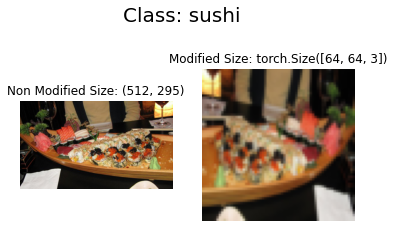

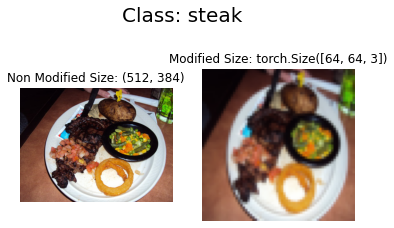

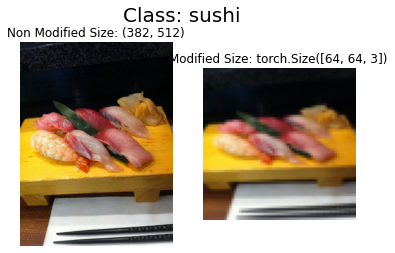

In [80]:
plot_transformed_images(image_paths=image_list,
                        transform=img_transform,
                        n=3,
                        seed=10)

## 4. Option 1: Loading image data using `ImageFolder`

**🟦EN**: We can load image classification data using `torchvision.dataset.ImageFolder`

**🟥ES**: Podemos cargar imagenes de classificación usando `torchvision.dataset.ImageFolder`


In [82]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=img_transform, # Transform from the data
                                  target_transform=None) # A transform for the label / target

test_data = datasets.ImageFolder(root=test_dir,
                                 transform=img_transform)

print(f"Train data\n#############\n{train_data}\n-------------------\nTest data\n#############\n{test_data}")                           

Train data
#############
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
-------------------
Test data
#############
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [83]:
# Class name as list
classes = train_data.classes
print(f"All classes: {classes}")

All classes: ['pizza', 'steak', 'sushi']


In [84]:
# Classes dict
classes_dict = train_data.class_to_idx
print(f"Classes dict: {classes_dict}")

Classes dict: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [87]:
# train_data.targets ==> Show all labels
train_data.samples[:5]

[('data/pizza_steak_sushi/train/pizza/1008844.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1033251.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1044789.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1089334.jpg', 0),
 ('data/pizza_steak_sushi/train/pizza/1105700.jpg', 0)]

In [92]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}\n\nImage shape: {img.shape}\nImage DType: {img.dtype}\n")
print(f"Label: {label}\nLable DType: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

In [94]:
permuted_img = img.permute(1, 2, 0)

# Print different shapes
print(f"Not modified shape: {img.shape} [color_channel, height, width]")
print(f"Permuted image: {permuted_img.shape} [height, width, color_channel]")

Not modified shape: torch.Size([3, 64, 64]) [color_channel, height, width]
Permuted image: torch.Size([64, 64, 3]) [height, width, color_channel]


(-0.5, 63.5, 63.5, -0.5)

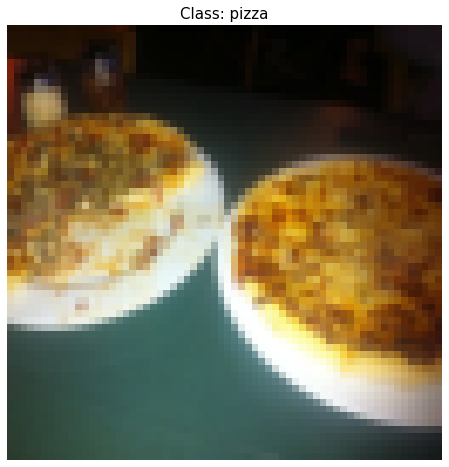

In [97]:
# Plot img
plt.figure(figsize=(8, 8))
plt.imshow(permuted_img)
plt.title(f"Class: {classes[label]}", fontsize=15)
plt.axis("off")

### 5.1 Turn loaded image into `DataLoader`

**🟦EN**: `DataLoader` is going to help us turn out `Dataset` into iterables and we can customise the `batch_size` so our model can see `batch_size` images at time

**🟥ES**:

In [100]:
# Train / test datasets => DataLoader
BATCH_SIZE = 32
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=os.cpu_count(),
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=1,
                             shuffle=False)

print(f"Train dataloader length: {len(train_dataloader)} || Test_dataloader length: {len(test_dataloader)}\nWith batch size of {BATCH_SIZE}")

Train dataloader length: 8 || Test_dataloader length: 3
With batch size of 32


AttributeError: ignored

## 6 Option 2: Load image with custom dataset
**🟦EN**:
1. Want to be able to load image from files
2. Want to be able to get class names from dataset
3. Want to be able to get classes as dictionary from dataset

*Pros*:
* Can create a `dataset` out of almost anything
* Not limited to PyTorch prebuild `Dataset`functions

*Cons*:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work
* Using custom `Datasat`often results in us writing more code, which could be prone to errors or performance issues. 

**🟥ES**:
1. Quiero ser capaz de cargar la imagen de los archivos
2. Desea poder obtener los nombres de las clases del conjunto de datos
3. Quiero ser capaz de obtener las clases como diccionario de conjunto de datos

*Pros
* Puede crear un `dataset` de casi cualquier cosa
* No está limitado a las funciones precompiladas de PyTorch.

*Desventajas
* Aunque puedas crear un `Dataset` a partir de casi cualquier cosa, no significa que funcione.
* Usar `Datasat` personalizados a menudo nos obliga a escribir más código, que puede ser propenso a errores o problemas de rendimiento. 


In [107]:
import os
import torch
import pathlib

from PIL import Image
from torchvision import transforms
from typing import Tuple, Dict, List
from torch.utils.data import Dataset

In [102]:
# Instance of torchvision.datasets.ImageFolder()
print(f"Traind data classes:{train_data.classes}\n\nDictionary data classes: {train_data.class_to_idx}")

Traind data classes:['pizza', 'steak', 'sushi']

Dictionary data classes: {'pizza': 0, 'steak': 1, 'sushi': 2}


### 6.1 Helper function to get class names

**🟦EN**:
1. Get class names with `os.scandir()` to travese a target directory 
2. Classes name => Dict and list and return
3. If the class name aren't found, raise a error.
**🟥ES**:
1. Obtener los nombres de las clases con `os.scandir()` para recorrer un directorio de destino 
2. Nombre de clases => Dict y lista y devuelve
3. Si el nombre de la clase no se encuentra, genera un error.


In [105]:
# Setup path
target_dir = train_dir
print(f"Target dir: {target_dir}")

# Get the class names
class_names_found = sorted([entry.name for entry in list(os.scandir(target_dir))])
print(f"Class names dir found: {class_names_found}")

Target dir: data/pizza_steak_sushi/train
Class names dir found: ['pizza', 'steak', 'sushi']


In [108]:
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  # Get class
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # Error if class names could not be found
  if not classes:
    raise FileNotFoundError(f"No classe found in {directory}")

  # Create dict (optim numbers than strings)
  class_to_idx = {class_name: i for i, class_name in enumerate(classes)}
  return classes, class_to_idx

In [109]:
find_classes(target_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

**🟦EN**:

**🟥ES**:


**🟦EN**:

**🟥ES**:


**🟦EN**:

**🟥ES**:
